In [1]:
import cv2
import torch
import torchvision
from tqdm import tqdm
import numpy as np
from IPython.display import Image
from monai.transforms import (
    apply_transform,
    Randomizable,
    Compose,
    OneOf,
    EnsureChannelFirstDict,
    LoadImageDict,
    SpacingDict,
    OrientationDict,
    DivisiblePadDict,
    CropForegroundDict,
    ResizeDict,
    RandZoomDict,
    ZoomDict,
    RandRotateDict,
    HistogramNormalizeDict,
    ScaleIntensityDict,
    ScaleIntensityRangeDict,
    ToTensorDict,
    Transform
)

In [2]:
%%bash
mkdir -p vis

In [3]:
import os
import glob
from tqdm.auto import tqdm

In [4]:
def glob_files(folders: str = None, extension: str = "*.nii.gz"):
    assert folders is not None
    paths = [
        glob.glob(os.path.join(folder, extension), recursive=True)
        for folder in folders
    ]
    files = sorted([item for sublist in paths for item in sublist])
    print(len(files))
    print(files[:1])
    return files

In [5]:
ct_folders = [
    "data/ChestXRLungSegmentation/NSCLC/processed/train/images",
]
ct_images = glob_files(
    ct_folders, 
    extension="*.nii.gz"
)

402
['data/ChestXRLungSegmentation/NSCLC/processed/train/images/LUNG1-001_0000.nii.gz']


In [6]:
class UnSqueezeDim(Transform):
    """
    Squeeze unnecessary unitary dimensions
    """

    def __init__(self, dim=None):
        """
        Args:
            dim (int): dimension to be squeezed.
                Default: None (all dimensions of size 1 will be removed)
        """
        if dim is not None:
            assert isinstance(dim, int) and dim >= -1, 'invalid channel dimension.'
        self.dim = dim

    def __call__(self, img):
        """
        Args:
            data (dict): dictionary of numpy arrays with dim removed,
        """
        return np.expand_dims(img, self.dim)

class SqueezeDim(Transform):
    """
    Squeeze unnecessary unitary dimensions
    """

    def __init__(self, dim=None):
        """
        Args:
            dim (int): dimension to be squeezed.
                Default: None (all dimensions of size 1 will be removed)
        """
        if dim is not None:
            assert isinstance(dim, int) and dim >= -1, 'invalid channel dimension.'
        self.dim = dim

    def __call__(self, img):
        """
        Args:
            data (dict): dictionary of numpy arrays with dim removed,
        """
        return np.squeeze(img, self.dim)

/home/quantm/anaconda3/envs/py310/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


Loading..  unet3d.ckpt


/home/quantm/anaconda3/envs/py310/lib/python3.10/site-packages/pytorch3d/renderer/implicit/raymarching.py:188: UserWarning: One or more elements of rays_densities are outside of validrange (0.0, 1.0)
  warnings.warn(


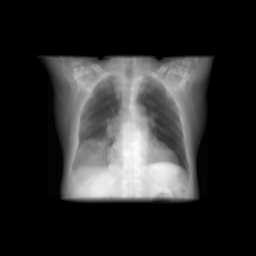

In [7]:
# Define the transformation pipeline for "image2d"
val_transforms_asl = Compose(
    [
        LoadImageDict(keys=["image3d"]),
        EnsureChannelFirstDict(keys=["image3d"],),
        SpacingDict(
            keys=["image3d"],
            pixdim=(1.0, 1.0, 1.0),
            mode=["bilinear"],
            align_corners=True,
        ),
        OrientationDict(keys=("image3d"), axcodes="ASL"),
        ScaleIntensityRangeDict(
            keys=["image3d"],
            clip=True,
            a_min=-1024,
            a_max=+3071,
            b_min=0.0,
            b_max=1.0,
        ),
        CropForegroundDict(
            keys=["image3d"],
            source_key="image3d",
            select_fn=(lambda x: x > 0),
            margin=0,
        ),
        ZoomDict(keys=["image3d"], zoom=0.95, padding_mode="constant", mode=["area"]),
        ResizeDict(
            keys=["image3d"],
            spatial_size=256,
            size_mode="longest",
            mode=["trilinear"],
            align_corners=True,
        ),
        DivisiblePadDict(
            keys=["image3d"],
            k=256,
            mode="constant",
            constant_values=0,
        ),
        ToTensorDict(keys=["image3d"],),
    ]
)

from nvlitmodel import NVLightningModule, make_cameras_dea
from dvr.renderer import ReverseXRayVolumeRenderer, ForwardXRayVolumeRenderer
# Run forward pass
device = torch.device('cuda:0')
B = 1
checkpoint_path = "test.ckpt"
model = NVLightningModule.load_from_checkpoint(checkpoint_path, strict=False).to(device)
model.fwd_renderer = ReverseXRayVolumeRenderer(
    image_width=256,
    image_height=256,
    n_pts_per_ray=400,
    min_depth=6.1,
    max_depth=9.9,
    ndc_extent=1.0,
)
dist_hidden = 8 * torch.ones(B, device=device)
elev_hidden = torch.zeros(B, device=device)
azim_hidden = torch.zeros(B, device=device)
view_hidden = make_cameras_dea(
    dist_hidden, 
    elev_hidden, 
    azim_hidden, 
    fov=16.0, 
    znear=6.1, 
    zfar=9.9,
).to(device)

data = {}
data["image3d"] = ct_images[1]
image3d = val_transforms_asl(data)

image3d = image3d["image3d"].to(device)
image3d = image3d.unsqueeze(0)
# print(image3d.shape)

output = model.forward_screen(
    image3d=image3d, 
    cameras=view_hidden, 
).clamp_(0, 1).squeeze().detach().cpu()
output = (255*output).astype(torch.uint8).unsqueeze(0) #.transpose(-1, -2)
# print(output.shape)

torchvision.io.write_png(output, f"vis/reverse_asl.png")
Image(filename="vis/reverse_asl.png")

/home/quantm/anaconda3/envs/py310/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


Loading..  unet3d.ckpt
ForwardXRayVolumeRenderer()
False


/home/quantm/anaconda3/envs/py310/lib/python3.10/site-packages/pytorch3d/renderer/implicit/raymarching.py:188: UserWarning: One or more elements of rays_densities are outside of validrange (0.0, 1.0)
  warnings.warn(


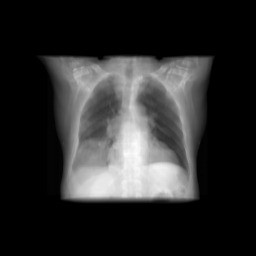

In [10]:
# Define the transformation pipeline for "image2d"
val_transforms_asl = Compose(
    [
        LoadImageDict(keys=["image3d"]),
        EnsureChannelFirstDict(keys=["image3d"],),
        SpacingDict(
            keys=["image3d"],
            pixdim=(1.0, 1.0, 1.0),
            mode=["bilinear"],
            align_corners=True,
        ),
        OrientationDict(keys=("image3d"), axcodes="ASL"),
        ScaleIntensityRangeDict(
            keys=["image3d"],
            clip=True,
            a_min=-1024,
            a_max=+3071,
            b_min=0.0,
            b_max=1.0,
        ),
        CropForegroundDict(
            keys=["image3d"],
            source_key="image3d",
            select_fn=(lambda x: x > 0),
            margin=0,
        ),
        ZoomDict(keys=["image3d"], zoom=0.95, padding_mode="constant", mode=["area"]),
        ResizeDict(
            keys=["image3d"],
            spatial_size=256,
            size_mode="longest",
            mode=["trilinear"],
            align_corners=True,
        ),
        DivisiblePadDict(
            keys=["image3d"],
            k=256,
            mode="constant",
            constant_values=0,
        ),
        ToTensorDict(keys=["image3d"],),
    ]
)

from nvlitmodel import NVLightningModule, make_cameras_dea
from dvr.renderer import ReverseXRayVolumeRenderer, ForwardXRayVolumeRenderer
# Run forward pass
device = torch.device('cuda:0')
B = 1
checkpoint_path = "test.ckpt"
model = NVLightningModule.load_from_checkpoint(checkpoint_path, strict=False).to(device)
model.fwd_renderer = ForwardXRayVolumeRenderer(
    image_width=256,
    image_height=256,
    n_pts_per_ray=400,
    min_depth=6.1,
    max_depth=9.9,
    ndc_extent=1.0,
)
print(model.fwd_renderer)
dist_hidden = 8 * torch.ones(B, device=device)
elev_hidden = torch.zeros(B, device=device)
azim_hidden = torch.zeros(B, device=device)
view_hidden = make_cameras_dea(
    dist_hidden, 
    elev_hidden, 
    azim_hidden, 
    fov=16.0, 
    znear=6.1, 
    zfar=9.9,
).to(device)

data = {}
data["image3d"] = ct_images[1]
image3d = val_transforms_asl(data)

image3d = image3d["image3d"].to(device)
image3d = image3d.unsqueeze(0)

output = model.forward_screen(
    image3d=image3d, 
    cameras=view_hidden, 
).clamp_(0, 1).squeeze().detach().cpu()
output = (255*output).astype(torch.uint8).unsqueeze(0) #.transpose(-1, -2)

torchvision.io.write_png(output, f"vis/forward_asl.png")

Image(filename="vis/forward_asl.png")

In [11]:
%%bash
diff vis/forward_asl.png vis/reverse_asl.png

Binary files vis/forward_asl.png and vis/reverse_asl.png differ


CalledProcessError: Command 'b'diff vis/forward_asl.png vis/reverse_asl.png\n'' returned non-zero exit status 1.